In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utide
import xarray as xr

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


In [2]:
data = "../data/wellington-071a-nzl-uhslc"
for i in range (1899,2021,20):
    year_start=str(i)
    year_end=str(i+20)
    print (year_start, year_end)
with open(data) as f:
    lines = f.readlines()

lines[:41]

1899 1919
1919 1939
1939 1959
1959 1979
1979 1999
1999 2019
2019 2039


['# FORMAT VERSION 5.0 Web: https://gesla.org Email: gesla.help@gmail.com\n',
 '# SITE NAME Wellington\n',
 '# SITE CODE 071A\n',
 '# COUNTRY NZL\n',
 '# CONTRIBUTOR University of Hawaii Sea Level Center\n',
 '# CONTRIBUTOR WEBSITE https://uhslc.soest.hawaii.edu\n',
 '# CONTRIBUTOR CONTACT philiprt@hawaii.edu\n',
 '# ORGINATOR  Land Information New Zealand, New Zealand \n',
 '# ORIGINATOR WEBSITE Unspecified\n',
 '# ORIGINATOR CONTACT Unspecified\n',
 '# LATITUDE     -41.28300000\n',
 '# LONGITUDE    174.78300000\n',
 '# COORDINATE SYSTEM Unspecified\n',
 '# START DATE/TIME 1944/11/18 00:00:00\n',
 '# END DATE/TIME 2018/12/31 11:00:00\n',
 '# NUMBER OF YEARS 75\n',
 '# TIME ZONE HOURS 0\n',
 '# DATUM INFORMATION Unspecified\n',
 '# INSTRUMENT Unspecified\n',
 '# PRECISION Unspecified\n',
 '# NULL VALUE -99.9999\n',
 '# GAUGE TYPE Coastal\n',
 '# OVERALL RECORD QUALITY No obvious issues\n',
 '# \n',
 '# CREATION DATE UTC 2021/11/02\n',
 '# \n',
 '# COLUMN 1 Date yyyy/mm/dd\n',
 '# COLUM

In [3]:
names = ["date", "hour", "sealevel", "flag", "use_flag"]

obs = pd.read_csv(
    data,
    names=names,
    skiprows=41, # to skip the large header and documentation, would need to check whether this is the same for every time series
    skipinitialspace=True,
    delim_whitespace=True,
    na_values="-99.9999",
)

good_data = obs['use_flag'] == 1
bad_data = obs['use_flag'] == 0

obs.loc[bad_data, "sealevel"] = np.nan
obs["anomaly"] = obs['sealevel'] - obs['sealevel'].mean()

obs['datetime'] = pd.to_datetime(obs['date'] + ' ' +obs['hour'])


obs

/vftmp/Olivia.Mcredmond/pid222300/ipykernel_223397/998701377.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  obs = pd.read_csv(


,date,hour,sealevel,flag,use_flag,anomaly,datetime
0,1944/11/18,00:00:00,0.885,1,1,-0.160702,1944-11-18 00:00:00
1,1944/11/18,01:00:00,0.845,1,1,-0.200702,1944-11-18 01:00:00
2,1944/11/18,02:00:00,0.925,1,1,-0.120702,1944-11-18 02:00:00
3,1944/11/18,03:00:00,1.035,1,1,-0.010702,1944-11-18 03:00:00
4,1944/11/18,04:00:00,1.265,1,1,0.219298,1944-11-18 04:00:00
...,...,...,...,...,...,...,...
649711,2018/12/31,07:00:00,0.586,1,1,-0.459702,2018-12-31 07:00:00
649712,2018/12/31,08:00:00,0.790,1,1,-0.255702,2018-12-31 08:00:00
649713,2018/12/31,09:00:00,0.979,1,1,-0.066702,2018-12-31 09:00:00
649714,2018/12/31,10:00:00,1.220,1,1,0.174298,2018-12-31 10:00:00


In [115]:
obs['datetime'][0]

Timestamp('1899-01-01 01:00:00')

In [83]:
for i in range (1899,2021,20):
    year_start=str(i)
    year_end=str(i+20)
    obs_t1=obs.loc[(obs['datetime'] >= year_start) & (obs['datetime'] <= year_end)]
    coef = utide.solve(
        obs_t1.datetime,
        obs_t1.anomaly,
        lat=-41.28300000,
        method="ols",
        conf_int="MC",
        verbose=False,)

    tide = utide.reconstruct(obs_t1.datetime, coef, verbose=False)

    obs_t1['sealevel_tr'] = obs_t1.anomaly - tide.h


{'t_in': 307848   1980-01-01 00:00:00
 307849   1980-01-01 01:00:00
 307850   1980-01-01 02:00:00
 307851   1980-01-01 03:00:00
 307852   1980-01-01 04:00:00
                  ...        
 483164   1999-12-31 20:00:00
 483165   1999-12-31 21:00:00
 483166   1999-12-31 22:00:00
 483167   1999-12-31 23:00:00
 483168   2000-01-01 00:00:00
 Name: datetime, Length: 175321, dtype: datetime64[ns],
 'epoch': None,
 'constit': None,
 'min_SNR': 2,
 'min_PE': 0,
 't_mpl': array([722815.        , 722815.04166667, 722815.08333333, ...,
        730119.91666667, 730119.95833333, 730120.        ]),
 'h': array([-0.2606759 , -0.02114252,  0.21379245, ...,  0.04258998,
         0.29148103,  0.46709777])}

In [84]:
obs_t1['sealevel_tr'] = obs_t1.anomaly - tide.h
obs_t1

/vftmp/Olivia.Mcredmond/pid222300/ipykernel_223397/249098168.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_t1['sealevel_tr'] = obs_t1.anomaly - tide.h


,date,hour,sealevel,flag,use_flag,anomaly,datetime,sealevel_tr
307848,1980/01/01,00:00:00,NaN,5,0,NaN,1980-01-01 00:00:00,NaN
307849,1980/01/01,01:00:00,NaN,5,0,NaN,1980-01-01 01:00:00,NaN
307850,1980/01/01,02:00:00,NaN,5,0,NaN,1980-01-01 02:00:00,NaN
307851,1980/01/01,03:00:00,NaN,5,0,NaN,1980-01-01 03:00:00,NaN
307852,1980/01/01,04:00:00,NaN,5,0,NaN,1980-01-01 04:00:00,NaN
...,...,...,...,...,...,...,...,...
483164,1999/12/31,20:00:00,0.728,1,1,-0.317702,1999-12-31 20:00:00,0.081416
483165,1999/12/31,21:00:00,0.955,1,1,-0.090702,1999-12-31 21:00:00,0.117955
483166,1999/12/31,22:00:00,1.235,1,1,0.189298,1999-12-31 22:00:00,0.146708
483167,1999/12/31,23:00:00,1.412,1,1,0.366298,1999-12-31 23:00:00,0.074817


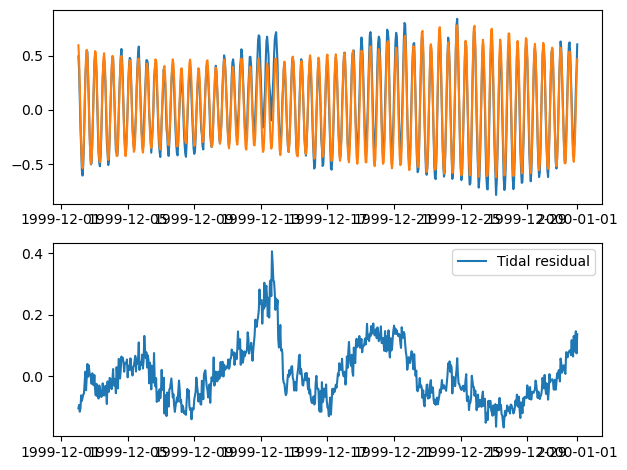

In [85]:
fig, axs = plt.subplots(ncols=1, nrows=2)

axs[0].plot(obs_t1.datetime[(-30*24):], obs_t1.anomaly[(-30*24):], label="Sea level anomalies from mean")
axs[0].plot(obs_t1.datetime[(-30*24):], tide.h[(-30*24):], label="Reconstructed tides")
#axs[0].legend()

axs[1].plot(obs_t1.datetime[(-30*24):], obs_t1.sealevel_tr[(-30*24):], label="Tidal residual")
axs[1].legend()

plt.tight_layout()

## We can now start to look at the distribution of tidal residuals and how our statistics may be sensitive to full sea level signals vs tidal residual signals

In [86]:
p999 = obs_t1.sealevel_tr.quantile(1-1e-4) # for hourly datasets a .9999 quantile is approximately once every 10 years
p999

0.45761512441339197

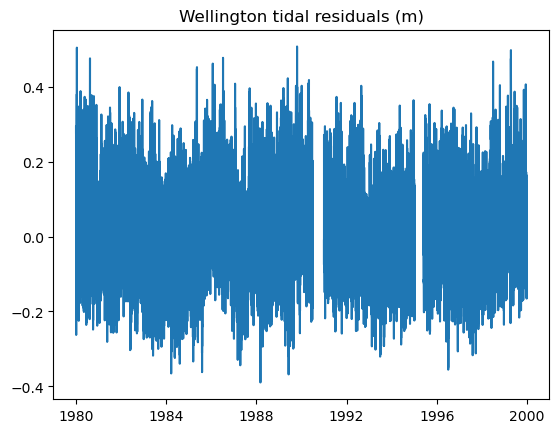

In [87]:
plt.plot(obs_t1.datetime, obs_t1.sealevel_tr, label="Sea level tidal residual")
#plt.text(pd.to_datetime('1916-09-01 05:00:00'), 2.3, 'Lake washington canal')
#plt.text(pd.to_datetime('1990-05-01 05:00:00'), 2.2, 'Hugo')
#plt.text(pd.to_datetime('2003-6-01 05:00:00'), 1.7, 'Matthew')
plt.title("Wellington tidal residuals (m)")
#plt.xlim(pd.to_datetime('1976-01-1'), pd.to_datetime('1976-12-31'))

plt.savefig(r"C:\Users\deros\Downloads\CIMES project\Wellington 2011-2021\Wellington_residuals.png", format="png")

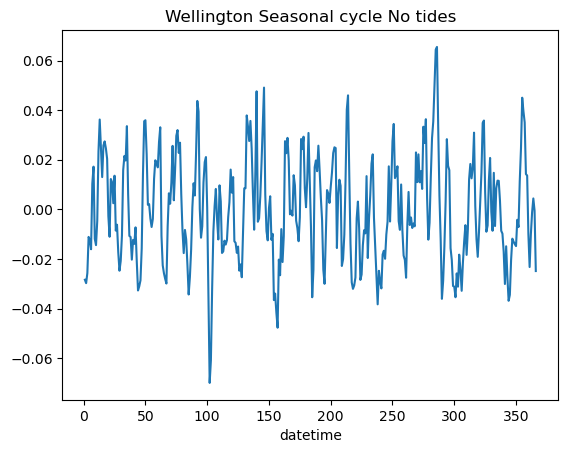

In [111]:
seasonal_Wellington = obs_t1.sealevel_tr.groupby(obs_t1.datetime.dt.dayofyear).mean()
(seasonal_Wellington - seasonal_Wellington.mean()).plot(label="Wellington")
plt.title("Wellington Seasonal cycle No tides")
plt.savefig(f"C:\\Users\\deros\\Downloads\\{year_start}-{year_end}", format="png")

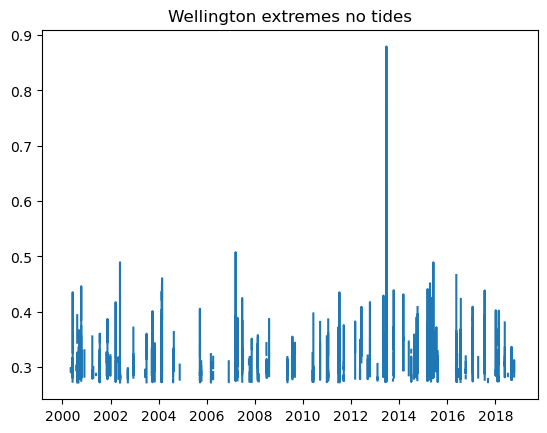

In [66]:
q99 = obs_t1.sealevel_tr.quantile(0.99)

ds_extreme = obs_t1.where(obs_t1.sealevel_tr >= q99)
plt.title("Wellington extremes no tides")

plt.plot(obs_t1.datetime, ds_extreme.sealevel_tr, label="Wellington Extremes")

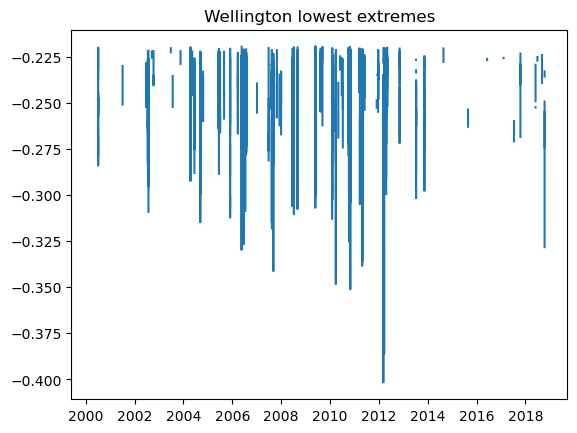

In [67]:
q99 = obs_t1.sealevel_tr.quantile(0.01)

ds_extreme_low = obs_t1.where(obs_t1.sealevel_tr <= q99)
plt.title("Wellington lowest extremes")

plt.plot(obs_t1.datetime, ds_extreme_low.sealevel_tr, label="Wellington lowest Extremes")

Text(0.5, 1.0, 'Wellington Extremes seasonal cycle no tides')

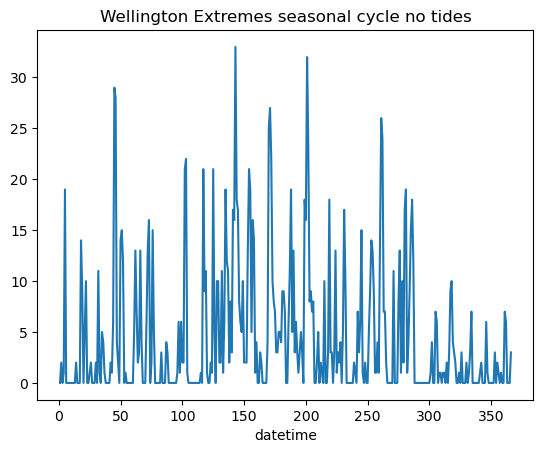

In [68]:
(ds_extreme.sealevel_tr.groupby(obs_t1.datetime.dt.dayofyear).count()).plot()
plt.title("Wellington Extremes seasonal cycle no tides")

Text(0.5, 1.0, 'Wellington Deviation from Mean Sea level No tides')

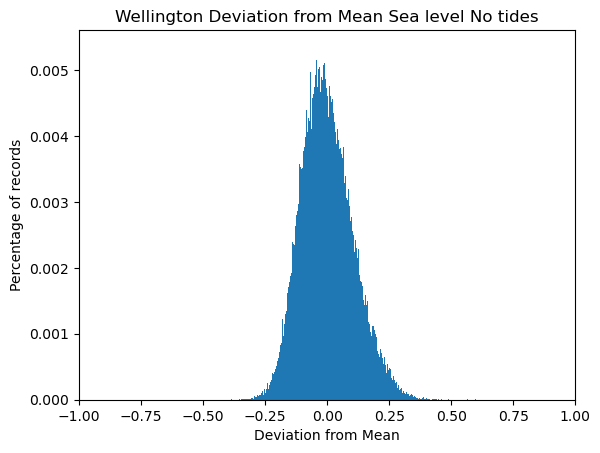

In [69]:
len(obs_t1.sealevel_tr)
obs_t1.sealevel_tr.plot.hist(bins=1000,weights=1/len(obs_t1.sealevel_tr) * np.ones(len(obs_t1.sealevel_tr)))
plt.xlim([-1,1])
plt.ylabel("Percentage of records")
plt.xlabel("Deviation from Mean")
plt.title("Wellington Deviation from Mean Sea level No tides")